# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

## Preprocesamiento

### Importamos las librerías

In [1]:
# Importamos las librerías que vamos a necesitar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm.notebook import tqdm
import gzip
import re
import nltk
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV

### Configuraciones

In [2]:
# Le doy formato a los gráficos
# sns.set_style("darkgrid")
sns.set_style("white")
plt.rc('font', size=10)
plt.rc('legend', fontsize=12)
plt.rc('axes', titlesize=16)
plt.rc('figure', titlesize=16)
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

In [3]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.4f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# Instanciamos método para ver el progreso de las operaciones sobre sobre los dataframes
tqdm.pandas()
# Indicador de tiempo de ejecución
%load_ext autotime

In [4]:
# Las siguientes lineas permiten habilitar o deshabilitar ciertas operaciones
# procesamiento de datos para ahorrar tiempo de procesamiento.
READ_RAW = True
PROCESS_TEXT = True
POLARITY = True

### Carga y limpieza inicial de datos

### Carga y limpieza inicial de datos

In [5]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

Dataset de **Reviews**

In [6]:
# Atencion: la carga de los datos tarda alrededor de 5 minutos 30 segundos
if READ_RAW:
    contador = 0
    data_reviews = []
    # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
    # abrira uno de cada tres, y asi.
    n = 10
    for l in tqdm(parse('steam_reviews.json.gz')):
        if contador%n == 0:
            data_reviews.append(l)
        else:
            pass
        contador += 1
    data_reviews = pd.DataFrame(data_reviews)

0it [00:00, ?it/s]

In [7]:
if READ_RAW:
    data_reviews.to_csv('data_reviews.csv', index_label='index')
else:
    data_reviews = pd.read_csv('data_reviews.csv')
    data_reviews.drop(columns='index', inplace=True)

In [8]:
# Previsualizamos las primeras 5 instancias del dataset
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1000,41.0000,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2000,1386.0000,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1000,1706.0000,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8000,2217.0000,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2000,18.0000,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [9]:
# Previsualizamos las ultimas 5 instancias del dataset
data_reviews.tail()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
779302,Vidaar,783.5000,353.0000,252490,1,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10217,NaN,NaN,NaN
779303,Nikolai Belinski,55.1000,204.0000,252490,1,2013-12-11,Coolest Game Eva,True,10218,NaN,NaN,NaN
779304,RancorZealot,203.5000,173.0000,252490,1,2013-12-11,Should you buy RUST? Uh... YES. The BEST Survi...,True,10219,76561197963920623,NaN,NaN
779305,Jerry,139.8000,79.0000,252490,1,2013-12-11,Great game!,True,10220,76561198042664856,NaN,NaN
779306,Helk,15375.0000,98.0000,252490,1,2013-12-11,I love this game!,True,10221,NaN,NaN,36.0000


In [10]:
# Reviso la informacion general del dataset
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      779307 non-null  object 
 1   hours         776670 non-null  float64
 2   products      777741 non-null  float64
 3   product_id    779307 non-null  object 
 4   page_order    779307 non-null  int64  
 5   date          779307 non-null  object 
 6   text          779307 non-null  object 
 7   early_access  779307 non-null  bool   
 8   page          779307 non-null  int64  
 9   user_id       317340 non-null  object 
 10  compensation  14588 non-null   object 
 11  found_funny   120164 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 66.1+ MB


In [11]:
# Vemos los missings
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [12]:
# Selecciono las columnas que me interesan y que creo que pueden ser de utilidad
columnas = ['username', 'hours', 'product_id', 'text','user_id']
data_reviews = data_reviews[columnas]
data_reviews.head()

,username,hours,product_id,text,user_id
0,Chaos Syren,0.1000,725280,This would not be acceptable as an entertainme...,NaN
1,Ariman1,13.2000,328100,Addictive RPG ! Works fine on linux though it ...,NaN
2,freakfantom,0.1000,725280,Прикольная стрелялка. Взял дешево на распродаже.,NaN
3,The_Cpt_FROGGY,7.8000,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,76561198003030375
4,the_maker988,8.2000,35140,"This game was way to linear for me, and compar...",76561198353396844


In [13]:
# Vemos los missings
data_reviews.isna().sum()

username           0
hours           2637
product_id         0
text               0
user_id       461967
dtype: int64

In [14]:
# Para las instancias que no tienen 'user id' voy a generar uno sintetico
# Como la columna de 'user id' tiene muchos missings, voy a generar un id
# para cada 'username'
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_reviews['user_id'] = le.fit_transform(data_reviews.username)

# data_reviews1 = data_reviews[~data_reviews.user_id.isna()]
# data_reviews2 = data_reviews[data_reviews.user_id.isna()]
# data_reviews1['uid'] = data_reviews1['user_id']
# data_reviews2['uid'] = le.fit_transform(data_reviews2.username)
# data_reviews = pd.concat([data_reviews1, data_reviews2])
data_reviews.head()

,username,hours,product_id,text,user_id
0,Chaos Syren,0.1000,725280,This would not be acceptable as an entertainme...,62543
1,Ariman1,13.2000,328100,Addictive RPG ! Works fine on linux though it ...,26902
2,freakfantom,0.1000,725280,Прикольная стрелялка. Взял дешево на распродаже.,434604
3,The_Cpt_FROGGY,7.8000,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,347904
4,the_maker988,8.2000,35140,"This game was way to linear for me, and compar...",503851


In [15]:
# Chequeo que no tengo missings
data_reviews.isna().sum()

username         0
hours         2637
product_id       0
text             0
user_id          0
dtype: int64

In [16]:
# Verifico los tipos de dato
data_reviews.dtypes

username       object
hours         float64
product_id     object
text           object
user_id         int32
dtype: object

In [17]:
# Redefino el tipo de dato de 'user_id' a int64
data_reviews['product_id'] = data_reviews['product_id'].astype(dtype='int64')
data_reviews['user_id'] = data_reviews['user_id'].astype(dtype='int64')
data_reviews.dtypes

username       object
hours         float64
product_id      int64
text           object
user_id         int64
dtype: object

In [18]:
# Exploro los estadisticos del dataset
data_reviews.describe(include='object')

,username,text
count,779307,779307
unique,540341,718779
top,123,
freq,213,1837


In [19]:
# Exploro más estadisticos del dataset
data_reviews.describe()

,hours,product_id,user_id
count,776670.0000,779307.0000,779307.0000
mean,111.8438,251489.8221,263409.6942
std,390.1454,149975.3705,154076.0211
min,0.0000,10.0000,0.0000
25%,4.0000,203770.0000,130630.5000
50%,15.3000,252490.0000,260873.0000
75%,59.6000,346110.0000,391980.0000
max,28164.0000,773900.0000,540340.0000


Dataset de **Games**

In [20]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [21]:
# Previsualizo las primeras 5 instancias
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.4900,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.9900,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8300,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.9900,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.7900,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.9900,False,773570,NaN,NaN,NaN


In [22]:
# Previsualizo las ultimas 5 instancias
data_games.tail()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.4900,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.9900,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.2400,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.9900,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.3900,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.9900,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.9900,False,658870,"xropi,stev3ns",1 user reviews,NaN
32134,NaN,NaN,Maze Run VR,NaN,http://store.steampowered.com/app/681550/Maze_...,NaN,"[Early Access, Adventure, Indie, Action, Simul...",NaN,http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.9900,True,681550,NaN,Positive,NaN


In [23]:
# Reviso la informacion general del dataset
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [24]:
# Vemos los missings
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [25]:
# Selecciono las columnas que me interesan
# Descarto la columna 'title' ya que tienen muchos missings y la columna 'app_name' tiene los nombres de los juegos
columnas = ['publisher', 'genres', 'app_name', 'tags', 'specs', 'price', 'id', 'developer', 'sentiment']
data_games = data_games[columnas]
data_games.head()

,publisher,genres,app_name,tags,specs,price,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.9900,761140,Kotoshiro,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,643980,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,670290,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.9900,767400,彼岸领域,NaN
4,NaN,NaN,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.9900,773570,NaN,NaN


In [26]:
# Trabajaremos sobre una copia del dataset de reviews
df_reviews = data_reviews.copy()

In [27]:
# Vemos los missings
data_games.isna().sum()

publisher    8052
genres       3283
app_name        2
tags          163
specs         670
price        1377
id              2
developer    3299
sentiment    7182
dtype: int64

In [28]:
# Descarto los missings de 'id' y de 'app_name'
data_games.dropna(axis=0, subset=['id', 'app_name'], inplace=True)

In [29]:
# Observamos los tipos de dato
data_games.dtypes

publisher    object
genres       object
app_name     object
tags         object
specs        object
price        object
id           object
developer    object
sentiment    object
dtype: object

In [30]:
# Cambio el tipo de dato de la columna 'id' para que coincida con la del dataframe 'data_reviews' 
data_games['id'] = data_games['id'].astype('int64')

In [31]:
# Chequeo los data types
data_games.dtypes

publisher    object
genres       object
app_name     object
tags         object
specs        object
price        object
id            int64
developer    object
sentiment    object
dtype: object

### Procesamiento de texto

A continuacion vamos a procesar el campo 'text' (que contiene los comentarios de las reviews) para inferir un 'rating' y ver si ese juego es de la preferencia o no del usuario.

In [32]:
# Trabajaremos sobre una copia del dataset de reviews
df_reviews = data_reviews.copy()

In [33]:
df_reviews.shape

(779307, 5)

#### Limpieza del campo 'text'

In [34]:
nltk.download('stopwords')
# Instanciamos el tokenizer
tokenizer=RegexpTokenizer("\w+")

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
stemmer = PorterStemmer()

# Traemos las stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Creo funcion para identificar el rol de cada palabra en el texto del comentario
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [251]:
# Creamos método para aplicar la Normalizacion y luega el Stemming a cada instancia
def processText(text):
    
    # Vamos a reemplzar los caracteres que no sean letras por espacios
    text = re.sub("[^a-zA-Z]"," ",str(text))
    
    # Pasamos todo a minúsculas
#     text = text.lower()
    
    # Tokenizamos para separar las palabras del titular
    text = tokenizer.tokenize(text)
    
    # Eliminamos las palabras de menos de 4 letras
    text = [palabra for palabra in text if len(palabra) >= 3]
    
    # Sacamos las Stopwords
    text = [p for p in text if not p in stopwords]
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
#     text = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    # Aplicamos la funcion para buscar la raiz de las palabras
#     text = [stemmer.stem(t) for t in text]
    
    # Por ultimo volvemos a unir el titular
    text = " ".join(text)
    
    return text

In [252]:
# Aplicamos la transformación
if PROCESS_TEXT:
    df_reviews['cleaned_text'] = df_reviews['text'].progress_apply(processText)
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv')
    df_reviews.drop(columns='index', inplace=True)

  0%|          | 0/779307 [00:00<?, ?it/s]

In [253]:
# Mostramos el dataset limpio
rand_list = np.random.choice(df_reviews.index, size=5)
df_reviews.loc[rand_list]

,username,hours,product_id,text,user_id,cleaned_text,polarity,rating,hr_factor,hr_rating,minimo,maximo
473547,Grievous,17.8000,16450,"the game is really good, action is a little re...",139371,game really good action little repetitive neve...,0.8410,4.6025,0.4686,4.1362,0.0000,24.2400
603624,[Kacho],5.1000,335670,"A difficult to complete indie RPG, LISA is dar...",393710,difficult complete indie RPG LISA dark humouro...,0.6801,4.2003,-0.8014,2.3455,0.0000,51.3700
604503,RON STAUHP,103.9000,231430,9/10 A lot of fun to play,273770,lot fun play,0.6908,4.2270,-0.7656,2.4037,0.0000,886.7000
713978,--= S.E.N.A.T.O.R =--,1.9000,274190,what a nice game,2723,nice game,0.4215,3.5537,-0.9361,1.8534,0.0000,59.5000
648267,Nightwing6400,6.6000,17410,This is the BEST parkor game I have ever playe...,241916,This BEST parkor game ever played This game ru...,0.9304,4.8260,-0.5642,2.9556,0.0000,30.2900


In [254]:
df_reviews.isna().sum()

username           0
hours           2637
product_id         0
text               0
user_id            0
cleaned_text       0
polarity           0
rating             0
hr_factor          0
hr_rating          0
minimo             0
maximo             0
dtype: int64

In [255]:
# df_reviews.cleaned_text = df_reviews.cleaned_text.str.strip()
# df_reviews.cleaned_text.replace('', np.nan, inplace=True)

In [256]:
df_reviews.isna().sum()

username           0
hours           2637
product_id         0
text               0
user_id            0
cleaned_text       0
polarity           0
rating             0
hr_factor          0
hr_rating          0
minimo             0
maximo             0
dtype: int64

In [257]:
# df_reviews.dropna(subset=['cleaned_text'], inplace=True)

#### Análisis de polaridad de los comentarios

In [258]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\elmai\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [259]:
sia = SentimentIntensityAnalyzer()
def polaridad(text):
    return sia.polarity_scores(text)['compound']

In [260]:
df_reviews.isna().sum()

username           0
hours           2637
product_id         0
text               0
user_id            0
cleaned_text       0
polarity           0
rating             0
hr_factor          0
hr_rating          0
minimo             0
maximo             0
dtype: int64

In [261]:
if POLARITY:
    df_reviews['polarity'] = df_reviews['cleaned_text'].progress_apply(polaridad)
    df_reviews.to_csv('df_reviews.csv', index_label='index')
else:
    df_reviews = pd.read_csv('df_reviews.csv')
    df_reviews.drop(columns='index', inplace=True)

  0%|          | 0/779307 [00:00<?, ?it/s]

In [262]:
# Creamos una columns de Rating entre 0 y 5, escalando la columna 'polarity'
column=df_reviews[['polarity']]
scaler = MinMaxScaler(feature_range=(0,5))
df_reviews['rating'] = scaler.fit_transform(column)
# df_reviews['rating'] = round(df_reviews['rating'] * 4) / 4
df_reviews.loc[rand_list]

,username,hours,product_id,text,user_id,cleaned_text,polarity,rating,hr_factor,hr_rating,minimo,maximo
473547,Grievous,17.8000,16450,"the game is really good, action is a little re...",139371,game really good action little repetitive neve...,0.8410,4.6025,0.4686,4.1362,0.0000,24.2400
603624,[Kacho],5.1000,335670,"A difficult to complete indie RPG, LISA is dar...",393710,difficult complete indie RPG LISA dark humouro...,0.6801,4.2003,-0.8014,2.3455,0.0000,51.3700
604503,RON STAUHP,103.9000,231430,9/10 A lot of fun to play,273770,lot fun play,0.6908,4.2270,-0.7656,2.4037,0.0000,886.7000
713978,--= S.E.N.A.T.O.R =--,1.9000,274190,what a nice game,2723,nice game,0.4215,3.5537,-0.9361,1.8534,0.0000,59.5000
648267,Nightwing6400,6.6000,17410,This is the BEST parkor game I have ever playe...,241916,This BEST parkor game ever played This game ru...,0.9304,4.8260,-0.5642,2.9556,0.0000,30.2900


In [263]:
# Mostramos el dataset limpio
df_reviews.loc[rand_list]

,username,hours,product_id,text,user_id,cleaned_text,polarity,rating,hr_factor,hr_rating,minimo,maximo
473547,Grievous,17.8000,16450,"the game is really good, action is a little re...",139371,game really good action little repetitive neve...,0.8410,4.6025,0.4686,4.1362,0.0000,24.2400
603624,[Kacho],5.1000,335670,"A difficult to complete indie RPG, LISA is dar...",393710,difficult complete indie RPG LISA dark humouro...,0.6801,4.2003,-0.8014,2.3455,0.0000,51.3700
604503,RON STAUHP,103.9000,231430,9/10 A lot of fun to play,273770,lot fun play,0.6908,4.2270,-0.7656,2.4037,0.0000,886.7000
713978,--= S.E.N.A.T.O.R =--,1.9000,274190,what a nice game,2723,nice game,0.4215,3.5537,-0.9361,1.8534,0.0000,59.5000
648267,Nightwing6400,6.6000,17410,This is the BEST parkor game I have ever playe...,241916,This BEST parkor game ever played This game ru...,0.9304,4.8260,-0.5642,2.9556,0.0000,30.2900


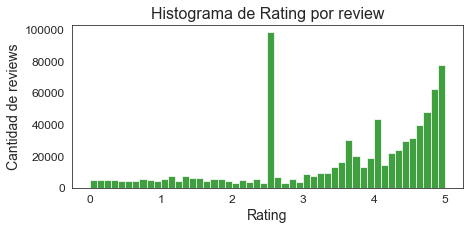

In [264]:
# Finalmente observamos la distribucion
plt.figure(figsize=(7,3))
sns.histplot(data=df_reviews, x='rating', color='green', label='rating', bins=50)
plt.title('Histograma de Rating por review')
# plt.legend()
plt.ylabel('Cantidad de reviews')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.show()

In [265]:
reviews_count = df_reviews.groupby('user_id').count().text.sort_values(ascending=False).reset_index().rename(columns={'text':'count'})
reviews_count.head()

,user_id,count
0,5463,213
1,19181,190
2,65614,155
3,240931,143
4,215286,137


In [266]:
df_ratings = df_reviews.groupby('product_id').agg({'rating':['count','mean']}).reset_index()
df_ratings.columns = ['product_id', 'count', 'rating_mean']
df_ratings.sort_values(by='rating_mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)
df_ratings

,product_id,count,rating_mean
0,430930,1,4.9990
1,486810,1,4.9985
2,410370,1,4.9983
3,551520,1,4.9977
4,505070,1,4.9975
...,...,...,...
12660,446250,1,0.0112
12661,661590,1,0.0107
12662,607700,1,0.0107
12663,675720,1,0.0055


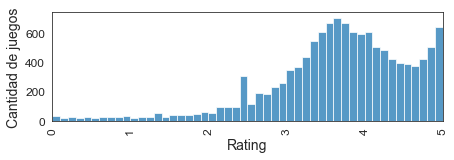

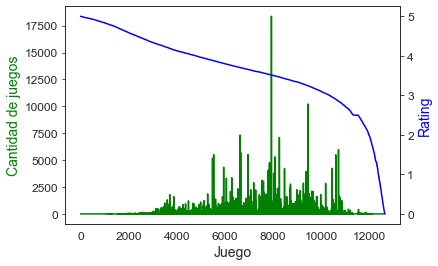

In [267]:
df_ratings.sort_values(by='rating_mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)
df_filter = df_ratings[df_ratings['count'] >= 1]

plt.figure(figsize=(7,2))
sns.histplot(data=df_filter, x='rating_mean', bins=50)
plt.ylabel('Cantidad de juegos')
plt.xlabel('Rating')
plt.xticks(rotation=90)
plt.xlim(0,5)
plt.show()

x = df_filter.index
y1 = df_filter['count']
y2 = df_filter['rating_mean']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Juego')
ax1.set_ylabel('Cantidad de juegos', color='g')
ax2.set_ylabel('Rating', color='b')

plt.show()

In [268]:
df_rep = df_reviews.groupby('cleaned_text').agg({'cleaned_text':'count','rating':'mean'})
df_rep[df_rep.cleaned_text > 3]
# df_reviews[df_reviews.cleaned_text == 'addictive']

,cleaned_text,rating
cleaned_text,,
,15434,2.5000
ADDICTING,6,2.5000
ADDICTIVE,4,2.5000
AMAZIN,5,2.5000
AMAZING,161,3.9647
...,...,...
yus,4,2.5000
zel,5,2.5000
zel oyun,6,2.5000


In [269]:
df_reviews.shape

(779307, 12)

## Filtro Colaborativo a partir de descomposición UV

#### Dataset y Train/Test Split

In [270]:
reader = Reader()
data = Dataset.load_from_df(df_reviews[['user_id', 'product_id', 'rating']], reader)
trainset, testset = train_test_split(data, random_state=42, test_size=.3)

#### Entrenamiento

In [271]:
from surprise import SVD, SVDpp, SlopeOne, BaselineOnly
algo = SVD()

In [272]:
algo.fit(trainset)

In [273]:
predictions = algo.test(testset)

In [274]:
accuracy.mae(predictions)
accuracy.rmse(predictions)

MAE:  1.0378
RMSE: 1.2684


1.2684478291318395

#### Optimizacion del Modelo

##### Optimizacion con Grid Search

In [71]:
param_grid = {'n_factors': [5,50,100,150],
              'n_epochs': [5,10,20],
              'lr_all': [0.001,0.002,0.005],
              'reg_all': [0.002,0.02,0.2]}

gs = RandomizedSearchCV(SVD,
                  param_grid,
                  measures=['rmse'],
                  cv=3,
                  n_jobs = -1,
                  joblib_verbose =10)

gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.7min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.8min remaining:   25.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.9min finished


In [72]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.2656191356494435
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


### Optmizacion del Rating

Una forma de mejorar la performance del modelo seria mejorar la calidad de los datos.
Debido a que contamos con la informacion del tiempo dedicado a cada juego por parte de cada jugador, podriamos inferir que cuanto mas tiempo le ha didcado el usuario al juego en cuestion, mas interes y por ende mayor preferencia por el juego representa.
Por todo esto, podriamos cuantificar las horas dedicadas a jugar dentro del rating: a mayor cantidad de tiempo, se le agregara un plus al rating calculado en base al comentario.

In [73]:
df_reviews.head()

,username,hours,product_id,text,user_id,cleaned_text,polarity,rating
0,Chaos Syren,0.1000,725280,This would not be acceptable as an entertainme...,62543,This would acceptable entertainment even back ...,0.7506,4.3765
1,Ariman1,13.2000,328100,Addictive RPG ! Works fine on linux though it ...,26902,Addictive RPG Works fine linux though minor bu...,0.2023,3.0057
2,freakfantom,0.1000,725280,Прикольная стрелялка. Взял дешево на распродаже.,434604,Прикольная стрелялка Взял дешево распродаже,0.0000,2.5000
3,The_Cpt_FROGGY,7.8000,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,347904,Somewhere Zibylon Zibylon command centre read ...,0.9729,4.9322
4,the_maker988,8.2000,35140,"This game was way to linear for me, and compar...",503851,This game way linear compared others good For ...,0.5859,3.9647


In [74]:
# Creamos un dataframe con las cantidad de horas minima y maxima dedicada a cada juego.
df_hours = df_reviews.groupby('product_id').hours.agg(minimo=np.min, maximo=np.max).sort_values(by='maximo', ascending=False)
df_hours

,minimo,maximo
product_id,,
224600,0.2000,28164.0000
8500,0.1000,23184.2000
320,0.1000,20573.3000
363970,0.0000,20018.9000
24010,0.1000,19205.2000
...,...,...
598390,NaN,NaN
604090,NaN,NaN
625660,NaN,NaN


In [75]:
# Redefinimos el mínimo en cero
df_hours.minimo = np.zeros(df_hours.shape[0])

In [76]:
# Vemos que hay missings. Vamos a ver cuantos hay.
df_hours.isna().sum()

minimo     0
maximo    45
dtype: int64

In [77]:
# Rellenamos los minimos con 0 y los maximos con 1
df_hours.minimo.fillna(0, inplace=True)
df_hours.maximo.fillna(1, inplace=True)
df_hours

,minimo,maximo
product_id,,
224600,0.0000,28164.0000
8500,0.0000,23184.2000
320,0.0000,20573.3000
363970,0.0000,20018.9000
24010,0.0000,19205.2000
...,...,...
598390,0.0000,1.0000
604090,0.0000,1.0000
625660,0.0000,1.0000


In [78]:
df_hours.reset_index(inplace=True)

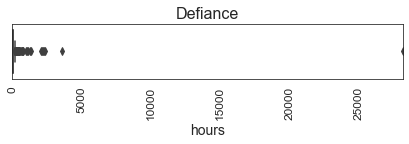

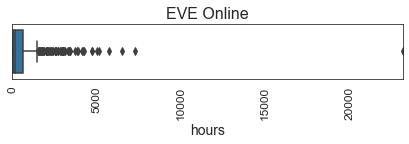

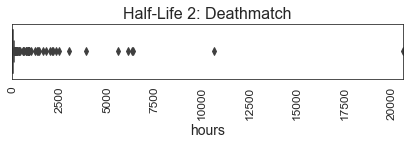

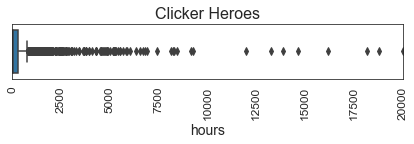

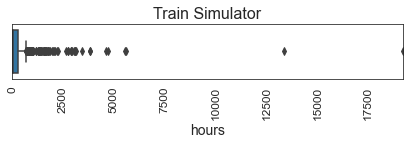

In [79]:
# Exploremos las densidaes de distribucion de horas de los juegos con mas horas
for product_id in df_hours[:5].product_id:    
    plt.figure(figsize=(7,1))
    sns.boxplot(data=df_reviews[df_reviews.product_id==product_id], x='hours')
    plt.title(data_games[data_games.id == product_id].app_name.values[0])
    plt.xlabel('hours')
    plt.xlim(0,df_hours[df_hours.product_id==product_id].maximo.values[0])
    plt.xticks(rotation=90)
    plt.show()

In [145]:
# Como vemos que existen muchos valores outliers,
# vamos a crear una funcion para topear el maximo
# en el percentil 90
def topMax(index):
    top = df_reviews[df_reviews.product_id==index].quantile(.90).hours
    if np.isnan(top):
        top = 1
    return top

In [146]:
df_hours['maximo'] = df_hours.product_id.progress_apply(topMax)
df_hours.sort_values(by='maximo', ascending=False)

  0%|          | 0/12665 [00:00<?, ?it/s]

,product_id,minimo,maximo
47,385020,0.0000,7290.4400
21,466170,0.0000,5535.8900
98,408030,0.0000,4217.8400
146,340990,0.0000,4038.6200
130,454550,0.0000,3525.0500
...,...,...,...
12615,8690,0.0000,0.0000
12616,44620,0.0000,0.0000
12617,355950,0.0000,0.0000
12618,331181,0.0000,0.0000


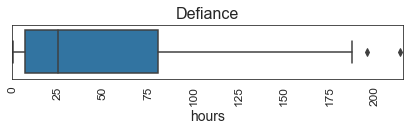

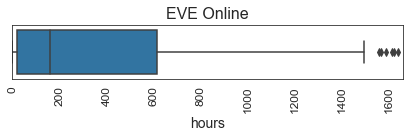

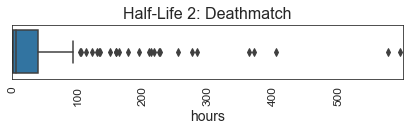

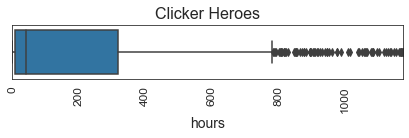

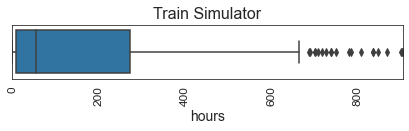

In [147]:
# Volvemos a chequear las distribuciones de los ratings por juego
for product_id in df_hours[:5].product_id:    
    plt.figure(figsize=(7,1))
    sns.boxplot(data=df_reviews[df_reviews.product_id==product_id], x='hours')
    plt.title(data_games[data_games.id == product_id].app_name.values[0])
    plt.xlim(0,df_hours[df_hours.product_id==product_id].maximo.values[0])
    plt.xticks(rotation=90)
    plt.show()

In [179]:
# Agrego las columnas de 'minimo' y 'maximo' al dataframe de las reviews
try:
    df_reviews.drop(['minimo', 'maximo'], axis=1, inplace=True)
except:
    df_reviews.head()
df_reviews = pd.merge(df_reviews, df_hours, how='left', left_on='product_id', right_on='product_id')
df_reviews.shape

(779307, 12)

In [181]:
df_reviews.columns

Index(['username', 'hours', 'product_id', 'text', 'user_id', 'cleaned_text',
       'polarity', 'rating', 'hr_factor', 'hr_rating', 'minimo', 'maximo'],
      dtype='object')

In [184]:
# Genero una nueva columna con normalizando la columna 'hours' entre -1 y 1
# Dicha columna, posteriormente se utilizará para sumar a la columna 'rating'
# De modo de considerar en la valoración, la cantidad de tiempo relativa que
# cada usuario dedico a jugar ese juego en particular. Así, si jugó muchas horas
# el 'hr_factor' estará más cerca de 1 y si jugo muy poco, estará más cerca de -1

df_reviews['hr_factor'] = np.minimum((df_reviews['hours']-df_reviews['minimo'])/(df_reviews['maximo']-df_reviews['minimo'])*2-1, 1)
df_reviews['hr_factor'] = df_reviews['hr_factor'].fillna(0)
df_reviews[['username', 'product_id', 'text', 'user_id', 'cleaned_text', 'polarity', 'rating', 'hours', 'minimo', 'maximo', 'hr_factor', 'hr_rating']]

,username,product_id,text,user_id,cleaned_text,polarity,rating,hours,minimo,maximo,hr_factor,hr_rating
0,Chaos Syren,725280,This would not be acceptable as an entertainme...,62543,This would acceptable entertainment even back ...,0.7506,4.3765,0.1000,0.0000,0.1000,1.0000,4.6880
1,freakfantom,725280,Прикольная стрелялка. Взял дешево на распродаже.,434604,Прикольная стрелялка Взял дешево распродаже,0.0000,2.5000,0.1000,0.0000,0.1000,1.0000,3.7491
2,Ariman1,328100,Addictive RPG ! Works fine on linux though it ...,26902,Addictive RPG Works fine linux though minor bu...,0.2023,3.0057,13.2000,0.0000,7.5600,1.0000,4.0021
3,dll3z,328100,do not buy this game,425514,buy game,0.0000,2.5000,0.4000,0.0000,7.5600,-0.8942,1.3436
4,Nyazicat,328100,For some reason I entirely derped out and boug...,247075,For reason entirely derped bought indiegala bu...,0.8058,4.5145,2.2000,0.0000,7.5600,-0.4180,2.7854
...,...,...,...,...,...,...,...,...,...,...,...,...
779302,rt974,518790,"Hi,\nI discovered this game yesterday on my pe...",488572,discovered game yesterday personal queue surpr...,0.9765,4.9413,9.4000,0.0000,122.6500,-0.8467,2.5994
779303,Fallenglory,518790,The Hunter was and is still the most realistic...,115945,The Hunter still realistic hunting sim release...,0.9688,4.9220,35.8000,0.0000,122.6500,-0.4162,2.9569
779304,GooseMan,518790,Very good!,137066,Very good,0.4927,3.7317,32.4000,0.0000,122.6500,-0.4717,2.3140
779305,lazyboy82,518790,Update after 60+ hours:\nI decided to quit the...,459109,Update hours decided quit game simply unfinish...,0.9771,4.9428,96.9000,0.0000,122.6500,0.5801,3.8169


In [185]:
# Verificamos que 'hr_factor' esté entre -1 y 1
df_reviews.describe()

,hours,product_id,user_id,polarity,rating,hr_factor,hr_rating,minimo,maximo
count,776670.0000,779307.0000,779307.0000,779307.0000,779307.0000,779307.0000,779307.0000,779307.0000,779307.0000
mean,111.8438,251489.8221,263409.6942,0.4266,3.5665,-0.2759,2.4675,0.0000,272.5729
std,390.1454,149975.3705,154076.0211,0.5230,1.3074,0.6565,1.0256,0.0000,443.5505
min,0.0000,10.0000,0.0000,-1.0000,0.0000,-1.0000,0.0000,0.0000,0.0000
25%,4.0000,203770.0000,130630.5000,0.0000,2.5000,-0.8406,1.8024,0.0000,25.2500
50%,15.3000,252490.0000,260873.0000,0.6124,4.0310,-0.4747,2.4530,0.0000,77.0000
75%,59.6000,346110.0000,391980.0000,0.8720,4.6800,0.1291,3.0527,0.0000,320.6600
max,28164.0000,773900.0000,540340.0000,1.0000,5.0000,1.0000,5.0000,0.0000,7290.4400


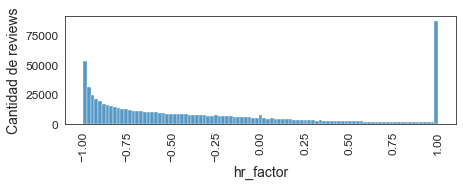

In [186]:
# Veamos la distribución de la variable
plt.figure(figsize=(7,2))
sns.histplot(data=df_reviews, x='hr_factor')
plt.ylabel('Cantidad de reviews')
plt.xlabel('hr_factor')
plt.xticks(rotation=90)
plt.show()

In [187]:
# ratings = []
# for n in tqdm(np.arange(df_reviews.shape[0])):
#     if df_reviews.iloc[n].polarity == 0:
#         rating = df_reviews.iloc[n].polarity + df_reviews.iloc[n].hr_factor
#     else:
#         rating = df_reviews.iloc[n].polarity
#     ratings.append(rating)

# df_reviews['hr_rating'] = ratings

In [188]:
# df_reviews['hr_rating'] = df_reviews['rating'] + df_reviews['hr_factor']

In [189]:
df_reviews['hr_rating'] = df_reviews['polarity'] + df_reviews['hr_factor']

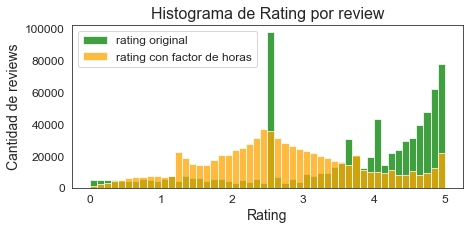

In [190]:
# Creamos la columna 'hr_rating' como la suma del 'rating' y 'hr_factor' 

# Y normalizamos entre 0 y 5
df_reviews['hr_rating'] = scaler.fit_transform(df_reviews[['hr_rating']])

# Finalmente observamos la distribucion
plt.figure(figsize=(7,3))
sns.histplot(data=df_reviews, x='rating', color='green', label='rating original', bins=50)
sns.histplot(data=df_reviews, x='hr_rating', color='orange', label='rating con factor de horas', bins=50)
plt.title('Histograma de Rating por review')
plt.legend()
plt.ylabel('Cantidad de reviews')
plt.xlabel('Rating')
plt.xticks(rotation=0)
plt.show()

In [191]:
# Recalculamos el 'rating' promedio por juego 
df_ratings = df_reviews.groupby('product_id').agg({'rating':['count','mean'], 'hr_rating':['mean']}).reset_index()
df_ratings.columns = ['product_id', 'count', 'rating_mean', 'hr_rating_mean']
df_ratings.sort_values(by='hr_rating_mean', ascending=False, inplace=True)
df_ratings.reset_index(inplace=True, drop=True)

df_ratings

,product_id,count,rating_mean,hr_rating_mean
0,430930,1,4.9990,4.9995
1,486810,1,4.9985,4.9992
2,410370,1,4.9983,4.9991
3,551520,1,4.9977,4.9989
4,505070,1,4.9975,4.9987
...,...,...,...,...
12660,515690,4,1.3934,1.4120
12661,426560,7,2.0102,1.3931
12662,411310,3,0.6216,1.3467
12663,537090,3,0.5393,1.2821


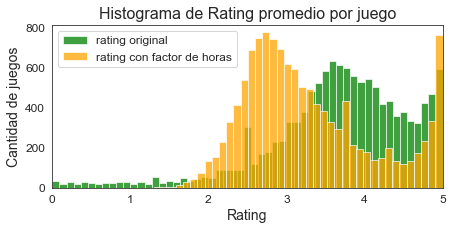

In [224]:
# Ahora vamos a graficar la comparacion entre las distribuciones
# de 'ratings' y 'hr_ratings'
df_filter = df_ratings[df_ratings['count'] >= 1]

plt.figure(figsize=(7,3))
sns.histplot(data=df_filter, x='rating_mean', color='green', label='rating original')
sns.histplot(data=df_filter, x='hr_rating_mean', color='orange', label='rating con factor de horas')
plt.title('Histograma de Rating promedio por juego')
plt.legend()
plt.ylabel('Cantidad de juegos')
plt.xlabel('Rating')
plt.xlim(0,5)
plt.xticks(rotation=0)
plt.show()

#### Dataset y Train/Test Split

In [225]:
df_filter_reviews = df_reviews[df_reviews.product_id.isin(df_filter.product_id)]
df_filter_reviews.shape

(779307, 12)

In [241]:
reader = Reader()
# data = Dataset.load_from_df(df_reviews[['user_id', 'product_id', 'hr_rating']], reader)
data = Dataset.load_from_df(df_filter_reviews[['user_id', 'product_id', 'hr_rating']], reader)
trainset, testset = train_test_split(data, random_state=42, test_size=.3)

#### Entrenamiento

In [242]:
from surprise import SVD, SVDpp, SlopeOne, BaselineOnly
algo = SVD()

In [243]:
algo.fit(trainset)

In [244]:
predictions = algo.test(testset)

In [245]:
accuracy.mae(predictions)
accuracy.rmse(predictions)

MAE:  0.8392
RMSE: 1.0690


1.0690241523884922

##### Optimizacion con Grid Search

#### Dataset y Train/Test Split

In [114]:
reader = Reader()
data = Dataset.load_from_df(df_reviews[['user_id', 'product_id', 'hr_rating']], reader)
trainset, testset = train_test_split(data, random_state=42, test_size=.2)

In [115]:
param_grid = {'n_factors': [5,50,100,150],
              'n_epochs': [5,10,20],
              'lr_all': [0.001,0.002,0.005],
              'reg_all': [0.002,0.02,0.2]}

gs = RandomizedSearchCV(SVD,
                  param_grid,
                  measures=['rmse'],
                  cv=3,
                  n_jobs = -1,
                  joblib_verbose =10)

gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.8min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.3min remaining:   59.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  3.6min remaining:   23.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.7min finished


In [116]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9809070330550943
{'n_factors': 5, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}
